In [367]:
#Imports + initializing tables
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from pandas import DataFrame

from sympy import symbols,diff
from math import log

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drive = pd.read_csv('./dataset/drivers.csv')
result = pd.read_csv('./dataset/results.csv')
race = pd.read_csv('./dataset/races.csv')
construct = pd.read_csv('./dataset/constructors.csv')
quali = pd.read_csv('./dataset/qualifying.csv')
laptimes = pd.read_csv('./dataset/lap_times.csv')

In [206]:
#Create new dataframe containing data with race completion times
mer1 = pd.merge(result,drive,on='driverId')
mer2 = pd.merge(mer1,race,on='raceId')
result2 = mer2[mer2.year>1995]
result2['driver'] = result2['forename'] + ' ' + result2['surname']
result2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9697 entries, 0 to 9696
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         9697 non-null   int64  
 1   raceId           9697 non-null   int64  
 2   driverId         9697 non-null   int64  
 3   constructorId    9697 non-null   int64  
 4   number_x         9697 non-null   object 
 5   grid             9697 non-null   int64  
 6   position         9697 non-null   object 
 7   positionText     9697 non-null   object 
 8   positionOrder    9697 non-null   int64  
 9   points           9697 non-null   float64
 10  laps             9697 non-null   int64  
 11  time_x           9697 non-null   object 
 12  milliseconds     9697 non-null   object 
 13  fastestLap       9697 non-null   object 
 14  rank             9697 non-null   object 
 15  fastestLapTime   9697 non-null   object 
 16  fastestLapSpeed  9697 non-null   object 
 17  statusId      

In [208]:
predResults = result2[['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'position','positionOrder', 'points', 'laps', 'milliseconds','circuitId', 'year', 'driver']]
finishes = predResults.loc[:9637, ['raceId', 'driverId','laps','positionOrder', 'milliseconds']]
laps = laptimes.loc[:487314, ['raceId', 'driverId', 'milliseconds']]

In [210]:
laps['milliseconds'] = pd.to_numeric(laps['milliseconds'], errors='coerce')
#Converting column from object to float by replacing \n entries with nan
finishes['milliseconds'] = pd.to_numeric(finishes['milliseconds'], errors='coerce')
finishes.dropna(axis=0, subset=['milliseconds'], inplace= True)
finishes.reset_index(drop=True)

,raceId,driverId,laps,positionOrder,milliseconds
0,18,1,58,1,5690616.0
1,18,2,58,2,5696094.0
2,18,3,58,3,5698779.0
3,18,4,58,4,5707797.0
4,18,5,58,5,5708630.0
...,...,...,...,...,...
4009,236,55,44,4,5314250.0
4010,236,57,44,3,5310835.0
4011,236,71,44,5,5324304.0
4012,236,77,44,6,5325021.0


In [203]:
finishes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4014 entries, 0 to 9633
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   raceId        4014 non-null   int64  
 1   driverId      4014 non-null   int64  
 2   laps          4014 non-null   int64  
 3   milliseconds  4014 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 156.8 KB


In [212]:
#Get appropriate variables then split them
#X = DataFrame(finishes, columns=['positionOrder'])
#Y = DataFrame(finishes, columns=['milliseconds'])
#Y.dropna()
#Y['milliseconds']
#Y['milliseconds'].astype(int)
#x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)
#x_train['laps'].max()
#Clean times up in order to use in visualisations + model, \n must be replaced or removed

In [220]:
#Create Linear Regression Model (can't be done with NaN)
#Divide intercept+ coef by 60000 to get time in minutes 
regr = LinearRegression()
regr.fit(x_train, y_train)
print('Intercept:', regr.intercept_[0] / 60000)
print('Coefficent:', regr.coef_[0][0] / 60000)
intercept_mins = regr.intercept_[0] / 60000
coef_mins = regr.coef_[0] /60000
lin_predicted = regr.predict(y_test)
lin_score = round(regr.score(x_train,y_train)*100, 2)
lin_score_test = round(regr.score(x_test, y_test) * 100, 2)
print('Score: ', lin_score)
print('Score test: ', lin_score_test)
print('Mean Squared Error: ', mean_squared_error(y_test, lin_predicted))
lin_predicted

model=DataFrame(list(zip(regr.intercept_, regr.coef_)), columns=['intercepts', 'coefficents'])

model.to_json(r'.\venv\modelTable.json', orient='table', index=True)
model

Intercept: 94.51573231884498
Coefficent: 0.41178631965390133
Score:  0.87
Score test:  0.12
Mean Squared Error:  2.1081505021568133e+22


,intercepts,coefficents
0,5.670944e+06,[24707.17917923408]


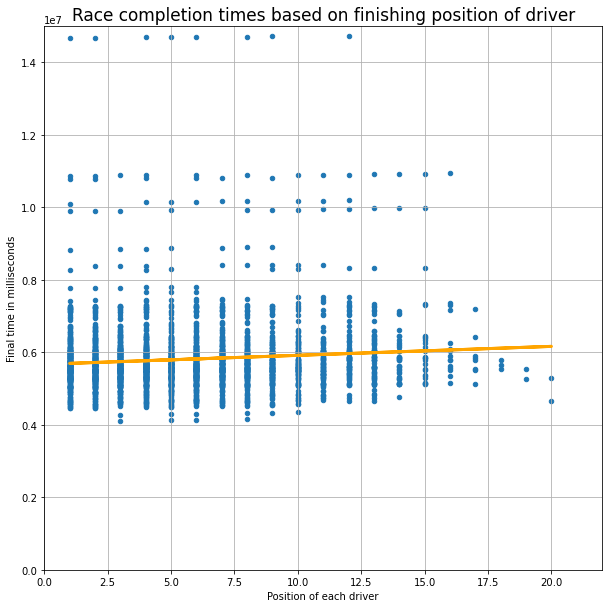

In [217]:
plt.figure(figsize=[10,10])
plt.xlim(0, 22)
plt.ylim(0, 15000000)
plt.title('Race completion times based on finishing position of driver', fontsize=17)
plt.scatter(x_train, y_train, s=20)
plt.plot(x_train, regr.predict(x_train), color='orange', linewidth=3)
plt.xlabel('Position of each driver')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.savefig('finalTimeOverLaps.png')
plt.show()

In [223]:
#filename = 'model1.pkl'
#pickle.dump(regr, (filename,'wb'))

#Attempt 2 at Linear Regression, requires better fitting
merged = mer2.drop(columns=['url_x', 'url_y', 'nationality', 'dob', 'code'])
merged['driver'] = merged['forename'] + ' ' + merged['surname']
merged = merged.drop(columns=['forename', 'surname'])
quali2020= quali[quali.raceId >= 1031]
results2020 = result[result.raceId >= 1031]
#bahrain2020 = merged[merged.raceId == 1045]
#abudhabi2020 = merged[merged.raceId == 1047]
#quali_bahrain2020 = quali[quali.raceId == 1045]
#quali_abudhabi2020 = quali[quali.raceId == 1047]
#bahrain2020 = bahrain2020.sort_values(by=['positionOrder'])
#abudhabi2020 = abudhabi2020.sort_values(by=['positionOrder'])
quali2020
raceQuali = pd.merge(results2020, quali2020, on=['raceId', 'driverId', 'constructorId'])
#race_Quali = pd.merge(merged['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'positionText'],
#                      quali2020['position'], left_on=['raceId', 'driverid'], right_on=['raceId', 'driverid'])
#raceQuali = raceQuali.fillna(0)
raceQuali = raceQuali.rename(columns={"position_y": "startGrid"})
#raceQuali['milliseconds'] = np.where(raceQuali['milliseconds'] == '\\N','0', raceQuali['milliseconds'])
raceQuali['milliseconds'] = pd.to_numeric(raceQuali['milliseconds'], errors='coerce')
raceQuali.dropna(axis=0, subset=['milliseconds'], inplace= True)
raceQuali['milliseconds'] = raceQuali['milliseconds'].astype(int)
raceQuali['finish'] = 0
raceQuali.info()
#raceQuali.drop['statusId', 'number_x', 'number_y']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 329
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         191 non-null    int64  
 1   raceId           191 non-null    int64  
 2   driverId         191 non-null    int64  
 3   constructorId    191 non-null    int64  
 4   number_x         191 non-null    object 
 5   grid             191 non-null    int64  
 6   position_x       191 non-null    object 
 7   positionText     191 non-null    object 
 8   positionOrder    191 non-null    int64  
 9   points           191 non-null    float64
 10  laps             191 non-null    int64  
 11  time             191 non-null    object 
 12  milliseconds     191 non-null    int32  
 13  fastestLap       191 non-null    object 
 14  rank             191 non-null    object 
 15  fastestLapTime   191 non-null    object 
 16  fastestLapSpeed  191 non-null    object 
 17  statusId        

In [197]:
#mod_x = raceQuali[['laps', 'startGrid']]
#mod_y = raceQuali[['milliseconds', 'positionOrder']]
mod_x = raceQuali[['startGrid']]
mod_y = raceQuali[['milliseconds']]
mod_x = mod_x.reset_index(drop=True)
mod_y = mod_y.reset_index(drop=True)
X_train, X_test, Y_train, Y_test = train_test_split(mod_x, mod_y, test_size = 0.3)
mod_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   startGrid  191 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [200]:
linRegr = LinearRegression()
linRegr = linRegr.fit(X_train, Y_train)
print('Intercept:', linRegr.intercept_[0])
print('Coefficent:', linRegr.coef_[0][0])
print('Score: ', linRegr.score(X_train, Y_train))

Intercept: 1.9023337238675078
Coefficent: 0.5669929771571369
Score:  0.546375673652571


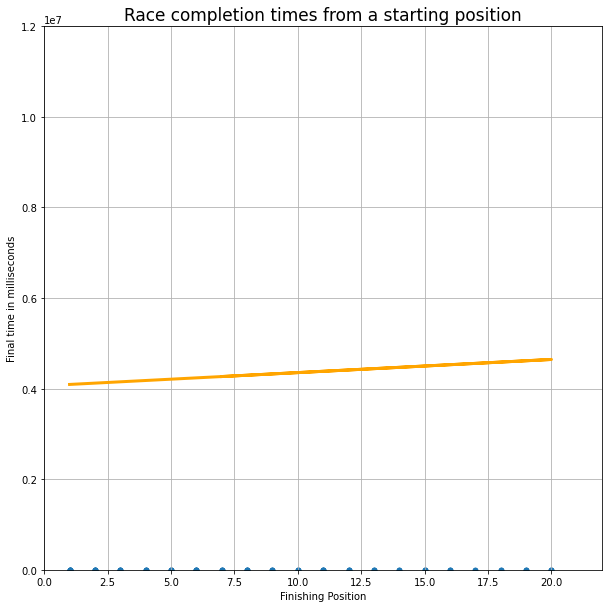

In [201]:
plt.figure(figsize=[10,10])
plt.xlim(0, 22)
plt.ylim(0, 12000000)
plt.title('Race completion times from a starting position', fontsize=17)
plt.scatter(X_train, Y_train, s=20)
plt.plot(X_train, regr.predict(X_train), color='orange', linewidth=3)
plt.xlabel('Finishing Position')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.show()

In [55]:
lastRace2020 =result2[result2.raceId == 1047]
lastRace2020 = pd.merge(lastRace2020,construct,on='constructorId')
lastRace = lastRace2020[['positionOrder', 'driver', 'name_y',  'points', 'time_x']]
lastRace = lastRace.sort_values(by=['positionOrder', 'points'], ascending=True, ignore_index=True)
lastRace = lastRace.rename_axis('key', axis=0)
lastRace
#result = lastRace.to_json(orient='table')
#parsed = json.loads(result)
lastRace.to_json(r'.\lastRaceTable.json', orient='table', index=True)
#lastRace.to_dict(orient='records')

In [427]:
#Attempt 3
data = result2.copy()
data['driver'] = data['forename'] + ' ' + data['surname']
data = data.drop(columns=['url_x', 'nationality', 'url_y', 'dob', 'code', 'statusId', 'driverRef', 'position', 'positionText', 'forename', 'surname', 'time_x', 'time_y', 'number_y', 'fastestLapTime', 'name', 'date'])
#data.number_y
data['milliseconds'] = pd.to_numeric(data['milliseconds'], errors='coerce')
data['fastestLapSpeed'] = pd.to_numeric(data['fastestLapSpeed'], errors='coerce')
data['rank'] = pd.to_numeric(data['rank'], errors='coerce')
data['fastestLap'] = pd.to_numeric(data['fastestLap'], errors='coerce')
#data['fastestLapTime'] = pd.to_numeric(data['fastestLapTime'], errors='coerce')
data.milliseconds = data.milliseconds.fillna(0)
data.fastestLapSpeed = data.fastestLapSpeed.fillna(0)
data['rank'] = data['rank'].fillna(0)
data.fastestLap = data.fastestLap.fillna(0)
#data.dropna(axis=0, subset=['milliseconds'], inplace= True)
#quali2020
data['podium'] = 0
result2['podium'] = 0


data2 = data[['circuitId', 'round', 'driver', 'grid', 'milliseconds','points', 'podium']]
data.drop_duplicates(inplace=True)
data

,resultId,raceId,driverId,constructorId,number_x,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,year,round,circuitId,driver,podium
0,1,18,1,1,22,1,1,10.0,58,5690616.0,39.0,2.0,218.300,2008,1,1,Lewis Hamilton,0
1,2,18,2,2,3,5,2,8.0,58,5696094.0,41.0,3.0,217.586,2008,1,1,Nick Heidfeld,0
2,3,18,3,3,7,7,3,6.0,58,5698779.0,41.0,5.0,216.719,2008,1,1,Nico Rosberg,0
3,4,18,4,4,5,11,4,5.0,58,5707797.0,58.0,7.0,215.464,2008,1,1,Fernando Alonso,0
4,5,18,5,1,23,3,5,4.0,58,5708630.0,43.0,1.0,218.385,2008,1,1,Heikki Kovalainen,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,4704,239,77,22,4,4,4,3.0,52,5580317.0,0.0,0.0,0.000,1996,16,22,Gerhard Berger,0
9693,4715,239,79,25,18,14,15,0.0,37,0.0,0.0,0.0,0.000,1996,16,22,Ukyo Katayama,0
9694,4712,239,83,18,20,18,12,0.0,50,0.0,0.0,0.0,0.000,1996,16,22,Pedro Lamy,0
9695,4705,239,84,17,12,10,5,2.0,52,5620911.0,0.0,0.0,0.000,1996,16,22,Martin Brundle,0


In [429]:
dfScaler = StandardScaler()
modelData = data.copy()
score = 0
lRegr = LinearRegression(fit_intercept= True, normalize= False)
trainingData = modelData[modelData.year < 2020]
x_train = trainingData.drop(['driver', 'podium'], axis=1)
y_train = trainingData.podium
x_train = pd.DataFrame(dfScaler.fit_transform(x_train), columns = x_train.columns)
lRegr.fit(x_train, y_train)
train = lRegr.predict(x_train)
results = trainingData['driver']

for track in modelData[modelData.year == 2020]['round'].unique():
    testData = modelData[(modelData.year == 2020)& (modelData['round'] == track)]
    x_test = testData.drop(['podium', 'driver'], axis = 1)
    y_test = testData['podium']
    x_test = pd.DataFrame(dfScaler.transform(x_test), columns=x_test.columns)
    
    predictions = pd.DataFrame(lRegr.predict(x_test), columns=['results'])
    predictions['podium'] = y_test.reset_index(drop=True)
    predictions['actual'] = predictions.podium.map(lambda x:1 if x ==1 else 0)
    predictions.sort_values(by=['results'],ascending= False, inplace= True)
    predictions['prediction'] = predictions.index
    predictions['prediction'] = predictions.prediction.map(lambda x: 1 if x == 0 else 0)
    score += precision_score(predictions.actual, predictions.prediction)
    #results.append(predictions['podium', 'actual', 'prediction'])
    

mScore = score / data[data.year == 2020]['round'].unique().max()

#Get rid of all NANs in modelData
#Fit LR model
#Currently returns one race (Sakhir)
#testData
#trainingData
outputPred = predictions
#outputPred['results'] = outputPred['results'].to_string()
predictions.to_json(r'.\venv\predTable.json', orient='table', index=True)
#testData
#outputPred
predictions

,results,podium,actual,prediction
2,1.188935,1,1,0
9,0.774742,1,1,0
11,0.706194,1,1,0
7,0.446933,0,0,0
3,0.404440,0,0,0
15,0.289867,0,0,0
6,0.232576,0,0,0
4,0.100094,0,0,0
16,0.009862,0,0,0
12,-0.017936,0,0,0


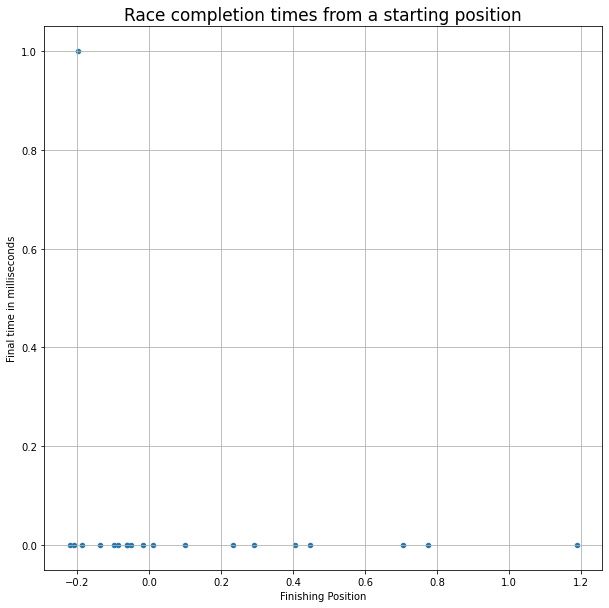

In [403]:
plt.figure(figsize=[10,10])
#plt.xlim(0, 22)
#plt.ylim(0, 12000000)
plt.title('Race completion times from a starting position', fontsize=17)
plt.scatter(predictions.results, predictions.prediction, s=20)
#plt.plot(x_train, lRegr.predict(x_train), color='orange', linewidth=3)
plt.xlabel('Finishing Position')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.show()

In [428]:
#data['podium'].size

for n in range(len(data.podium)):
    if(data.loc[n].at['positionOrder'] <= 3):
            data.at[n, 'podium'] = 1
    else:
        data.at[n, 'podium'] = 0

In [361]:
#Drop NAN from positionOrder

#data.dropna(axis=0, subset=['positionOrder'], inplace= True)
data.podium.unique()
data

,resultId,raceId,driverId,constructorId,number_x,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,year,round,circuitId,driver,podium
0,1,18,1,1,22,1,1,10.0,58,5690616.0,39.0,2.0,218.300,2008,1,1,Lewis Hamilton,True
1,2,18,2,2,3,5,2,8.0,58,5696094.0,41.0,3.0,217.586,2008,1,1,Nick Heidfeld,True
2,3,18,3,3,7,7,3,6.0,58,5698779.0,41.0,5.0,216.719,2008,1,1,Nico Rosberg,True
3,4,18,4,4,5,11,4,5.0,58,5707797.0,58.0,7.0,215.464,2008,1,1,Fernando Alonso,False
4,5,18,5,1,23,3,5,4.0,58,5708630.0,43.0,1.0,218.385,2008,1,1,Heikki Kovalainen,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,4704,239,77,22,4,4,4,3.0,52,5580317.0,0.0,0.0,0.000,1996,16,22,Gerhard Berger,False
9693,4715,239,79,25,18,14,15,0.0,37,0.0,0.0,0.0,0.000,1996,16,22,Ukyo Katayama,False
9694,4712,239,83,18,20,18,12,0.0,50,0.0,0.0,0.0,0.000,1996,16,22,Pedro Lamy,False
9695,4705,239,84,17,12,10,5,2.0,52,5620911.0,0.0,0.0,0.000,1996,16,22,Martin Brundle,False


In [379]:
modelData[(modelData.year == 2020)& (modelData['round'] == track)]

,resultId,raceId,driverId,constructorId,number_x,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,year,round,circuitId,driver,podium
8239,24939,1046,8,51,7,18,14,0.0,87,5501267.0,56.0,13.0,222.305,2020,16,3,Kimi Räikkönen,False
8240,24937,1046,20,6,5,13,12,0.0,87,5497725.0,56.0,5.0,224.141,2020,16,3,Sebastian Vettel,False
8241,24926,1046,815,211,11,5,1,25.0,87,5475114.0,69.0,3.0,224.599,2020,16,3,Sergio Pérez,True
8242,24930,1046,817,4,3,7,5,10.0,87,5488444.0,57.0,6.0,223.850,2020,16,3,Daniel Ricciardo,False
8243,24933,1046,822,131,77,1,8,4.0,87,5490503.0,60.0,2.0,225.497,2020,16,3,Valtteri Bottas,False
8244,24940,1046,825,210,20,15,15,0.0,87,5507484.0,57.0,16.0,221.760,2020,16,3,Kevin Magnussen,False
8245,24932,1046,826,213,26,6,7,6.0,87,5489648.0,80.0,7.0,223.764,2020,16,3,Daniil Kvyat,False
8246,24929,1046,832,1,55,8,4,12.0,87,5487694.0,80.0,9.0,223.122,2020,16,3,Carlos Sainz,False
8247,24944,1046,830,9,33,3,19,0.0,0,0.0,0.0,0.0,0.000,2020,16,3,Max Verstappen,False
8248,24927,1046,839,4,31,11,2,18.0,87,5485632.0,75.0,12.0,222.402,2020,16,3,Esteban Ocon,True


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 16],
      dtype=int64)